In [1]:
import numpy as np
import pandas as pd

In [2]:
#https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a

In [3]:
#UV - 0 = n/a, 1 = bright, 2 = medium, 3 = dim, 4 = none
#Classification - 0 = RSG, 1 = binary

In [4]:
# read in stars with known classifications
known = pd.read_csv("Known_v3.csv")
known.head()

,2MASS,logL,Umag,Bmag,Vmag,Imag,U-B,B-V,Classification,UV
0,05254484-6904488,5.020,15.903,15.164,13.516,99.999,0.739,1.648,0,4
1,05262739-6910559,5.112,16.733,15.474,13.626,99.999,1.259,1.848,0,4
2,05272673-6900018,4.815,16.323,14.964,13.136,99.999,1.359,1.828,0,0
3,05335217-6911135,5.083,17.580,16.214,13.807,9.425,1.366,2.407,0,4
4,05020953-7025017,4.910,16.563,15.164,13.316,10.493,1.399,1.848,0,4


In [5]:
# read in stars with unknown classifications
unknown = pd.read_csv("Unknown_v3.csv")
unknown2 = unknown.drop(columns=['2MASS'])
unknown2.head()

,logL,Umag,Bmag,Vmag,Imag,U-B,B-V,UV
0,4.553,99.999,18.119,13.152,9.772,-18.119,4.967,4
1,4.054,16.285,20.253,14.259,12.780,-3.968,5.994,4
2,3.752,14.602,18.450,14.877,13.485,-3.848,3.573,3
3,3.650,15.458,19.261,15.087,13.816,-3.803,4.174,4
4,4.422,15.643,19.113,13.523,11.844,-3.470,5.590,4


In [6]:
print(len(unknown2))
unknown2 = unknown2[unknown2["logL"]>4.2]
print(len(unknown2))

3697
908


In [7]:
unknown2 = unknown2.drop(columns=['logL'])

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
features = [['Umag','Bmag','Vmag','Imag','U-B','B-V','UV']]
for feature in features:
    known[feature] = scaler.fit_transform(known[feature])
    unknown2[feature] = scaler.fit_transform(unknown2[feature])

In [9]:
# begin defining classifier. Drop ID, Umag (too often absent), and Classification
X = known.drop(columns=['2MASS','Classification','logL'])
y = known['Classification'].values

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn2 = KNeighborsClassifier(weights='distance')

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
hyperparameters = dict(leaf_size=[1], n_neighbors=n_neighbors, p=p)

#create a dictionary of all values we want to test for n_neighbors
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, hyperparameters, cv=15)
#fit model to data
knn_gscv.fit(X, y)

GridSearchCV(cv=15, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='distance'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': [1],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29],
                         'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [11]:
print('Best leaf_size:', knn_gscv.best_estimator_.get_params()['leaf_size'])
print('Best p:', knn_gscv.best_estimator_.get_params()['p'])
print('Best n_neighbors:', knn_gscv.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 26


In [12]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'leaf_size': 1, 'n_neighbors': 26, 'p': 1}

In [13]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.9338596491228071

In [14]:
# classifier is knn_gscv
predProb = knn_gscv.predict_proba(unknown2)
np.savetxt("predProb.txt",predProb,delimiter=',')
print(predProb)

[[1.         0.        ]
 [0.88506101 0.11493899]
 [1.         0.        ]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]


In [15]:
pred = knn_gscv.predict(unknown2)

In [16]:
binG = np.sum(predProb[:,1])
binK = len(known[known["Classification"]==1])

In [17]:
singG = np.sum(predProb[:,0])
singK = len(known[known["Classification"]==0])

In [18]:
errorV = len(predProb)-len(predProb)*0.9338596491228071

In [19]:
per = (binG+binK)/(singG+singK)*100
perM = (binG-errorV+binK)/(singG+errorV+singK)*100
perP = (binG+errorV+binK)/(singG-errorV+singK)*100

In [20]:
perP

21.339346937778426

In [21]:
import matplotlib.pyplot as plt

In [37]:
uMb = [-0.011, -0.144, -0.171, -0.251, -0.268, -0.307, -0.354, -0.631, -0.703, 0.006, 0.269, 0.464, 0.469, 0.743, 0.795, 0.819, 0.829, 0.929, 0.947, 0.984, 1.129, -0.211, 0.299]
bMv = [1.198, 1.438, 1.058, 1.282, 1.204, 1.319, 1.049, 0.428, 0.734, 1.258, 1.438, 1.79, 1.248, 1.732, 1.507, 1.578, 1.708, 1.538, 1.725, 1.884, 1.798, 0.888, 1.508]

In [32]:
knownOrig = pd.read_csv("Known_v3.csv")
unknownOrig = unknown[unknown["logL"]>4.2]

In [33]:
len(unknownOrig)

908

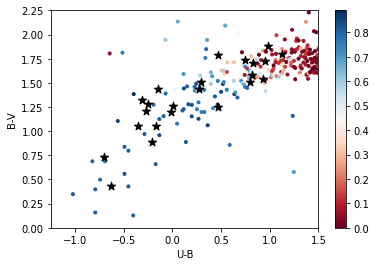

In [55]:
cm = plt.cm.get_cmap('RdBu')
sc = plt.scatter(unknownOrig['U-B'],unknownOrig['B-V'],c=predProb[:,1],cmap=cm,marker='.')
plt.colorbar(sc)
plt.scatter(uMb,bMv,marker='*',c='black',s=75)
plt.xlabel("U-B")
plt.ylabel("B-V")
plt.xlim([-1.25,1.5])
plt.ylim([0,2.25])
plt.savefig("predHST.eps")

In [ ]:
cm = plt.cm.get_cmap('RdBu')
sc = plt.scatter(knownOrig['U-B'],knownOrig['B-V'],c=knownOrig["Classification"],cmap=cm,marker='.')
plt.colorbar(sc)
plt.xlabel("U-B")
plt.ylabel("B-V")
plt.xlim([-1.5,4])
plt.ylim([-0.5,3])
plt.savefig("known.eps")

In [ ]:
# 2MASS, U,B,V,I,U-B,B-V,Galex, Spectra,Bin Likelihood
no = unknown[unknown["logL"] > 4]
yes = knownOrig

In [ ]:
np.savetxt("predProb.txt",predProb,delimiter=',')
no.to_csv("no.txt")
yes.to_csv("yes.txt")

In [ ]:
twoMass = pd.read_csv("2mass.csv")

In [ ]:
no2mass = pd.merge(twoMass, no, on='2MASS')
yes2mass = pd.merge(twoMass, yes, on='2MASS')

In [ ]:
twoMass

In [ ]:
plt.plot(no2mass["J-K"],no2mass["K"],'ro')
plt.plot(yes2mass["J-K"],yes2mass["K"],'bo')
plt.ylim([11,6])
plt.show()

In [ ]:
len(yes2mass[yes2mass["K"] > 1.0])/len(no2mass[no2mass["J-K"] < 1.0])

In [ ]:
len(yes2mass[yes2mass["J-K"] > 1.2])/len(no2mass[no2mass["J-K"] > 1.2])

In [ ]:
twoMassProp = pd.read_csv("2massProps.csv")

In [ ]:
no2mass = pd.merge(twoMassProp, no, on='2MASS')
yes2mass = pd.merge(twoMassProp, yes, on='2MASS')

In [ ]:
no2massR = ((5777/no2mass["Teff"])**2)*(10**no2mass["logL_x"])**(1/2)
yes2massR = ((5777/yes2mass["Teff"])**2)*(10**yes2mass["logL_x"])**(1/2)

In [ ]:
len(yes2massR[yes2massR < 300])/len(no2massR[no2massR < 300])

In [ ]:
len(yes2massR[yes2massR > 300])/len(no2massR[no2massR > 300])

In [ ]:
len(no2massR[no2massR < 500])

In [ ]:
len(no2massR[no2massR > 500])

### 

In [ ]:
yesSpec = yes2mass[yes2mass["Classification"] == 1]
noSpec = yes2mass[yes2mass["Classification"] == 0]

In [ ]:
kNNresult = no2mass

In [ ]:
cm = plt.cm.get_cmap('RdBu')
plt.scatter(kNNresult["Teff"],kNNresult["logL_x"],c=predProb[:,1],cmap=cm,marker='.')
plt.scatter(noSpec["Teff"],noSpec["logL_x"],color="#67001f",marker=".")
plt.scatter(yesSpec["Teff"],yesSpec["logL_x"],color="#053061",marker=".")
plt.xlabel(r"$T_{\rm{eff}} (K)$")
plt.ylabel("$\log~L/L_{\odot}$")
plt.colorbar(sc)
plt.xlim([4350,3400])
plt.ylim([4.0,5.7])
#plt.show()
plt.savefig("HRD.eps")

In [ ]:
from pylab import *

cmap = cm.get_cmap('RdBu', 3)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))